In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import glob, os
import scipy.stats as stats
from scipy.stats import gaussian_kde
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import r2_score
import timeit
%matplotlib inline

In [2]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read data

In [3]:
data = pd.read_csv('H:/fast trip/Copy of KC_Metro_4_15_2014_OBS_Data.csv')
#data = pd.read_csv('H:/fast trip/Copy of KC_Metro_4_15_2014_OBS_Data.csv', index_col=0)

In [4]:
data.columns

Index([u'TRIP_ID', u'PATTERN_ID', u'BLK', u'RTE', u'DIR', u'SCH_ST_MIN',
       u'OPD_DATE', u'VEHICLE_ID', u'BUS_TYPE', u'ENGINE', u'NUM_DOORS',
       u'STOP_SEQ', u'STOP_NAME', u'STOP_ID', u'SCH_STOP_SEC', u'ACT_STOP_ARR',
       u'SCH_STOP_TM', u'ACT_STOP_TM', u'DWELL_SEC', u'ACT_STOP_DEP',
       u'DOORS_OPEN', u'DOOR_OPEN_SEC', u'APC_VEH', u'ONS', u'OFFS', u'LOAD',
       u'GPS_LONGITUDE', u'GPS_LATITUDE'],
      dtype='object')

In [5]:
print data.shape

(396481, 28)


# my_data

In [6]:
def content_need(data):
    data = data[['TRIP_ID', 'RTE', 'VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS', 'STOP_SEQ', 'STOP_ID',
                 'DWELL_SEC', 'DOOR_OPEN_SEC', 'ONS', 'OFFS', 'LOAD']]
    return data

In [7]:
my_data = content_need(data)

In [8]:
my_data.columns

Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS',
       u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS',
       u'OFFS', u'LOAD'],
      dtype='object')

# Data preparation

# Capacity info

In [9]:
#should input a capacity table here, and joined the vehicle id to capacity info



# Step1: Clean data

In [13]:
def clean_data(data):
    start = timeit.default_timer()
    # Before cleaning records, get the load data from the previous stop
    data = data.sort(['TRIP_ID', 'STOP_SEQ'])
    data['pre_load'] = data['LOAD'].shift()
    
    # Remove the corner data (fist and last stops) before the data was disordered by other cleaning processes
    def del_stop(data):
        return data.iloc[1:-1]
    data = data.groupby('TRIP_ID', group_keys=False).apply(del_stop)
    print 'clean first and last stops', data.shape
    
    #data = data[pd.notnull(data['pre_load'])]
    #print 'clean invalid pre_load', data.shape
    
    # 0< Dwell time < 120 
    data = data[data['DOOR_OPEN_SEC'] != 0]
    #data = data[data['DOOR_OPEN_SEC'] != 0]
    print 'cleaned zero dwell', data.shape
    data = data[data['DOOR_OPEN_SEC'] <= 120]
    #data = data[data['DOOR_OPEN_SEC'] <= 120]
    print 'cleaned large dwell', data.shape
    
    # On + off != 0
    data = data[pd.notnull(data['ONS'])]
    data = data[data['ONS'] + data['OFFS'] != 0]
    print 'cleaned the invalid or zero boarding+alighting records:', data.shape
    
    # valid bus type
    data = data[data.BUS_TYPE != '??']
    print 'cleaned unknow bus type', data.shape
    
    # delete all downtown tunnel stop records
    dict_stop_id = dict((el,1) for el in [455, 456, 501, 502, 532, 533, 565, 566, 621, 622, 623, 624, 
                                      1082, 1083, 1084, 1086, 1108, 1109, 1121, 1122, 1192, 1193])
    data['downtown_stop'] = data['STOP_ID'].map(dict_stop_id)
    data.downtown_stop = data.downtown_stop.fillna(0)
    data = data[data.downtown_stop != 1]
    print 'cleaned downtown tunnel', data.shape
    stop = timeit.default_timer()
    print 'removed invalid data:', stop - start
    
    return data

In [14]:
step1 = clean_data(my_data)

clean first and last stops (374691, 13)
cleaned zero dwell (189444, 13)
cleaned large dwell (188303, 13)
cleaned the invalid or zero boarding+alighting records: (49989, 13)
cleaned unknow bus type (48980, 13)
cleaned downtown tunnel (47715, 14)
removed invalid data: 7.92990250234


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [15]:
step1.columns

Index([u'TRIP_ID', u'RTE', u'VEHICLE_ID', u'BUS_TYPE', u'NUM_DOORS',
       u'STOP_SEQ', u'STOP_ID', u'DWELL_SEC', u'DOOR_OPEN_SEC', u'ONS',
       u'OFFS', u'LOAD', u'pre_load', u'downtown_stop'],
      dtype='object')

# Step2: Prepare basic variables

In [16]:
def get_x_y(data): 
    start = timeit.default_timer()
    # Bus type: Articulated or Standard bus; TWo or Three doors
    data['Artic'] = data['BUS_TYPE'].map({'Artic': 1, 'Standard': 0})
    data['twodoors'] = data['NUM_DOORS'].map({2: 1, 3: 0})
    data['threedoors'] = data['NUM_DOORS'].map({2: 0, 3: 1})
    data['TwoDoorsArtic'] = data['twodoors'] * data['Artic']
    data['ThreeDoorsArtic'] = data['threedoors'] * data['Artic']
    # All door boarding: Rapid ride or not
    data['rapid_ride'] = data['RTE'].map({671: 1, 672: 1, 673: 1, 674: 1, 675: 1})
    data.rapid_ride = data.rapid_ride.fillna(0)
    print data.shape
    
    # Passenger activity
    data['ON+OFF'] = data['ONS'] + data['OFFS']
    data['max_pasg'] = data[['ONS', 'OFFS']].max(axis=1)
    data['abs_pasg'] = (data['ONS'] - data['OFFS']).abs()
    #data['pre_standees']= data['pre_load'] - 0.60 * data['capacity']
    #data['pre_crowding']= data.apply(lambda x: x['pre_standees'] > 0, axis=1).map({False: 0, True: 1})
    #data['friction'] = ((data['ONS'] + data['OFFS'] + (data['pre_standees']).abs()) * data['pre_crowding']).abs()
    print data.shape
    
    # Interactive vars
    data['OnsTwoDoorsArtic'] = data['ONS'] * data['TwoDoorsArtic']
    data['OffsTwoDoorsArtic'] = data['OFFS'] * data['TwoDoorsArtic']
    data['OnsThreeDoorsArtic'] = data['ONS'] * data['ThreeDoorsArtic']
    data['OffsThreeDoorsArtic'] = data['OFFS'] * data['ThreeDoorsArtic']
    data['OnsRapid'] = data['ONS'] * data['rapid_ride']
    data['OffsRapid'] = data['OFFS'] * data['rapid_ride']
    #data['OnsDowntown'] = data['ONS'] * data['downtown_stop']
    #data['OffsDowntown'] = data['OFFS'] * data['downtown_stop']
    print data.shape
    stop = timeit.default_timer()
    print 'add basic variables:', stop - start
    
    return data

In [17]:
step2 = get_x_y(step1)

(47715, 20)
(47715, 23)
(47715, 29)
add basic variables: 0.090227293308


# Step3: Prepare control variable: Vehnicle ID

In [18]:
len(np.unique(step2.VEHICLE_ID))

334

In [19]:
# Create dummie variables for bus id 
def create_vehID(data):
    start = timeit.default_timer()
    #data['vehno_date'] = data.vehno.astype(str) + '_' + data.date_id.astype(str)
    just_dummies_veh = pd.get_dummies(data['VEHICLE_ID'])
    data = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    #step_1.drop([8515], inplace=True, axis=1)
    stop = timeit.default_timer()
    print 'data shape:', data.shape
    print 'add vehid variables:', stop - start
    
    return data

In [20]:
step3 = create_vehID(step2)

data shape: (47715, 363)
add vehid variables: 0.421767031906


# Step4: Delete a vehicle variable in each bus type

In [21]:
test = step3
# There are four independ bus types fullfill the dataset, no route type involved at here
df_std = test.loc[test.Artic == 0]
df_art_2d= test.loc[(test.Artic == 1) & (test.twodoors == 1)]
df_art_3d_rap = test.loc[(test.Artic == 1) & (test.twodoors == 0) & (test.rapid_ride == 1)]
df_art_3d_notrap = test.loc[(test.Artic == 1) & (test.twodoors == 0) & (test.rapid_ride == 0)]

In [22]:
# Get the bus IDs, who runs one route type in a day. 
def del_vehID(data):
    start = timeit.default_timer()
    df_std = test.loc[test.Artic == 0]
    std_veh = np.unique(df_std['VEHICLE_ID'])[1]
    print 'std_veh:', std_veh
    
    df_art_2d= test.loc[(test.Artic == 1) & (test.twodoors == 1)]
    art_2d_veh = np.unique(df_art_2d['VEHICLE_ID'])[1]
    print 'art_2d:', art_2d_veh
    
    df_art_3d_rap = test.loc[(test.Artic == 1) & (test.twodoors == 0) & (test.rapid_ride == 1)]
    art_3d_rap_veh = np.unique(df_art_3d_rap['VEHICLE_ID'])[1]
    print 'art_3d_rapid_veh:', art_3d_rap_veh
    
    df_art_3d_norap = test.loc[(test.Artic == 1) & (test.twodoors == 0) & (test.rapid_ride == 0)]
    art_3d_notrap_veh = np.unique(df_art_3d_notrap['VEHICLE_ID'])[1]
    print 'art_3d_notrapid_veh:', art_3d_notrap_veh
    
    data = data.drop([std_veh, art_2d_veh, art_3d_rap_veh, art_3d_notrap_veh], 1)
    print 'data shape:', data.shape
    
    stop = timeit.default_timer()
    print 'deleted vehicle variables', stop - start
    
    return data

In [23]:
step4 = del_vehID(test) #double checked four vehicles were eliminated

std_veh: 1101
art_2d: 2601
art_3d_rapid_veh: 6004
art_3d_notrapid_veh: 4201
data shape: (47715, 359)
deleted vehicle variables 0.173087929005


In [26]:
my_project = step4

# Create training (70%) and validating (30%) dataset 

In [27]:
msk = np.random.rand(len(my_project)) < 0.7
df_train = my_project[msk]
df_test = my_project[~msk]

In [28]:
print df_train.shape
print df_test.shape

(33304, 359)
(14411, 359)


# Correlation table

In [29]:
#correlation table
results = my_project[['ONS', 'OFFS', 'TwoDoorsArtic', 'ThreeDoorsArtic', 'rapid_ride', 'max_pasg']]
results.corr()

,ONS,OFFS,TwoDoorsArtic,ThreeDoorsArtic,rapid_ride,max_pasg
ONS,1.000,0.045,0.027,0.074,0.072,0.679
OFFS,0.045,1.000,0.042,0.064,0.060,0.718
TwoDoorsArtic,0.027,0.042,1.000,-0.483,-0.425,0.067
ThreeDoorsArtic,0.074,0.064,-0.483,1.000,0.880,0.069
rapid_ride,0.072,0.060,-0.425,0.880,1.000,0.064
max_pasg,0.679,0.718,0.067,0.069,0.064,1.000


# Build multi-linear regression model

# Model 1 - with vehicle ids

Create a LinearRegression object 

In [30]:
df_train.columns[:40]

Index([            u'TRIP_ID',                 u'RTE',          u'VEHICLE_ID',
                  u'BUS_TYPE',           u'NUM_DOORS',            u'STOP_SEQ',
                   u'STOP_ID',           u'DWELL_SEC',       u'DOOR_OPEN_SEC',
                       u'ONS',                u'OFFS',                u'LOAD',
                  u'pre_load',       u'downtown_stop',               u'Artic',
                  u'twodoors',          u'threedoors',       u'TwoDoorsArtic',
           u'ThreeDoorsArtic',          u'rapid_ride',              u'ON+OFF',
                  u'max_pasg',            u'abs_pasg',    u'OnsTwoDoorsArtic',
         u'OffsTwoDoorsArtic',  u'OnsThreeDoorsArtic', u'OffsThreeDoorsArtic',
                  u'OnsRapid',           u'OffsRapid',                   1100,
                         1103,                   1104,                   1105,
                         1108,                   1113,                   1114,
                         1118,                   113

In [32]:
# Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train.drop(['TRIP_ID','RTE','VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS','STOP_SEQ',
               'STOP_ID','DWELL_SEC','DOOR_OPEN_SEC', 'LOAD', 'downtown_stop', 'ON+OFF', 'Artic','twodoors', 'threedoors', 'abs_pasg' ], axis=1)

X_test = df_test.drop(['TRIP_ID','RTE','VEHICLE_ID', 'BUS_TYPE', 'NUM_DOORS','STOP_SEQ',
               'STOP_ID','DWELL_SEC','DOOR_OPEN_SEC', 'LOAD', 'downtown_stop', 'ON+OFF', 'Artic','twodoors', 'threedoors','abs_pasg'], axis=1)

y_train = df_train.DOOR_OPEN_SEC
y_test = df_test.DOOR_OPEN_SEC

stop = timeit.default_timer()
print 'prepare x,y for regression:', stop - start

prepare x,y for regression: 0.545536840834


Run Linear Regression In Python SciKit-Learn

In [33]:
start = timeit.default_timer()
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results1 = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results1['pvalues'] = pd.DataFrame(pvalues)
sklearn_results1['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 0.846386247698


In [480]:
print sklearn_results1

                features  estimatedCoefficients  pvalues    scores
0                    ONS                  4.400    0.000 47474.133
1                   OFFS                  2.549    0.000 17934.766
2               pre_load                 -0.047    0.000 16701.634
3          TwoDoorsArtic                  6.816    0.747   108.393
4        ThreeDoorsArtic                  5.970    0.000   514.651
5             rapid_ride                  1.991    0.000   512.007
6               max_pasg                 -0.808    0.000 43598.531
7       OnsTwoDoorsArtic                 -0.798    0.000 27087.672
8      OffsTwoDoorsArtic                 -0.437    0.000 11334.361
9     OnsThreeDoorsArtic                 -0.949    0.000 20738.082
10   OffsThreeDoorsArtic                 -0.047    0.000  8489.940
11              OnsRapid                 -0.748    0.000 17478.135
12             OffsRapid                 -0.744    0.000  7273.094
13                  1100                  9.133    0.001   173

In [34]:
sklearn_results1.to_csv('R:/Angela/fast_trips/KCMetro/withVeh_DOOR_OPEN_SEC_MAXpasg_03032016.csv')

In [35]:
R2 = r2_score(y_train, pred_train) 
print R2

0.458848114504


In [36]:
c = X_train.corr().abs()
s = c.unstack()
so = s.order(kind="quicksort")

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


In [37]:
print len(so)
soo = so.dropna()
soo = soo[soo >= 0.500]
soo = soo[soo != 1.0]
print len(soo)

117649
24


In [38]:
soo

OnsRapid             rapid_ride            0.501
rapid_ride           OnsRapid              0.501
OnsRapid             ONS                   0.511
ONS                  OnsRapid              0.511
OffsThreeDoorsArtic  ThreeDoorsArtic       0.515
ThreeDoorsArtic      OffsThreeDoorsArtic   0.515
OffsRapid            rapid_ride            0.531
rapid_ride           OffsRapid             0.531
ONS                  OnsThreeDoorsArtic    0.549
OnsThreeDoorsArtic   ONS                   0.549
ONS                  OnsTwoDoorsArtic      0.620
OnsTwoDoorsArtic     ONS                   0.620
OffsTwoDoorsArtic    OFFS                  0.664
OFFS                 OffsTwoDoorsArtic     0.664
max_pasg             ONS                   0.681
ONS                  max_pasg              0.681
OFFS                 max_pasg              0.716
max_pasg             OFFS                  0.716
ThreeDoorsArtic      rapid_ride            0.880
rapid_ride           ThreeDoorsArtic       0.880
OffsThreeDoorsArtic 

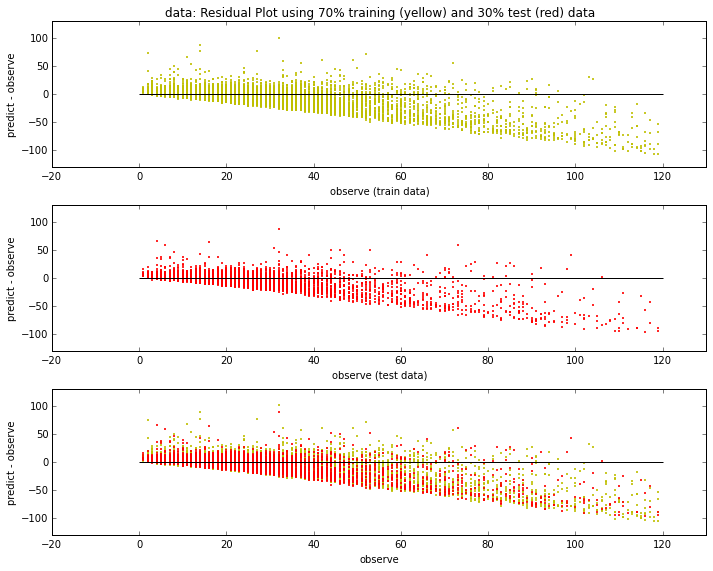

In [40]:
plt.figure(1)

plt.subplot(311)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y_train, lm1.predict(X_train) - y_train, c='y', s=1, edgecolor='y')
plt.scatter(y_test, lm1.predict(X_test) - y_test, c='r', s=1, edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.tight_layout()
plt.figure(figsize=(10,5))
#pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

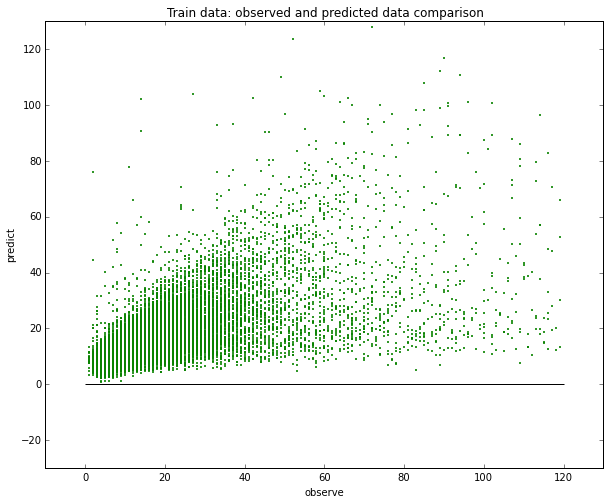

In [41]:
plt.figure(1)

plt.scatter(y_train, lm1.predict(X_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.show()

finished calculating z: 7.59548130037
finished sorting data: 0.000908569531248


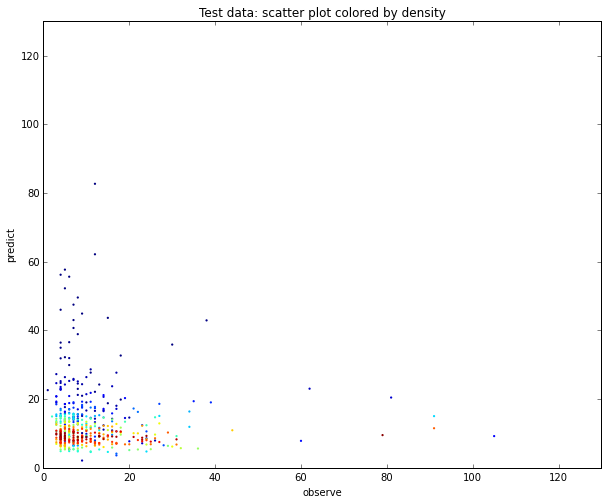

In [42]:
x = y_test
y = lm1.predict(X_test)

# Calculate the point density
start = timeit.default_timer()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
stop = timeit.default_timer()
print 'finished calculating z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z.argsort()
stop = timeit.default_timer()
print 'finished sorting data:', stop - start

x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=5, edgecolor='')
plt.axis([0, 130, 0, 130])
plt.title('Test data: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()


# Model2 - without vehicle ID

In [43]:
X2_train = df_train[['ONS', 'OFFS', 'ThreeDoorsArtic', 'TwoDoorsArtic', 'rapid_ride', 'max_pasg', 
                     'OnsTwoDoorsArtic','OffsTwoDoorsArtic', 'OnsThreeDoorsArtic', 'OffsThreeDoorsArtic', 
                     'OnsRapid', 'OffsRapid']]
X2_test = df_test[['ONS', 'OFFS', 'ThreeDoorsArtic', 'TwoDoorsArtic', 'rapid_ride', 'max_pasg', 
                     'OnsTwoDoorsArtic','OffsTwoDoorsArtic', 'OnsThreeDoorsArtic', 'OffsThreeDoorsArtic', 
                     'OnsRapid', 'OffsRapid']]
y2_train = y_train
y2_test = y_test

In [44]:
start = timeit.default_timer()
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
pred_train2 = lm2.predict(X2_train)
pred_test2 = lm2.predict(X2_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

# Construct a data frame that contains features and estimated coefficients
sklearn_results2 = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
# p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results2['pvalues'] = pd.DataFrame(pvalues)
sklearn_results2['scores'] = pd.DataFrame(scores)

stop = timeit.default_timer()
print 'build model with veh&day ids:', stop - start

build model with veh&day ids: 0.0994373509614


In [45]:
print sklearn_results2

               features  estimatedCoefficients  pvalues    scores
0                   ONS                  4.273    0.000 67456.801
1                  OFFS                  2.378    0.000 20749.369
2       ThreeDoorsArtic                  3.703    0.000   352.281
3         TwoDoorsArtic                  0.569    0.285   126.250
4            rapid_ride                 -1.835    0.000   213.169
5              max_pasg                 -0.978    0.000 55176.749
6      OnsTwoDoorsArtic                 -0.705    0.000 38983.737
7     OffsTwoDoorsArtic                 -0.463    0.000 11730.568
8    OnsThreeDoorsArtic                 -0.461    0.000 23766.759
9   OffsThreeDoorsArtic                 -0.429    0.000  9103.360
10             OnsRapid                 -1.024    0.000 18542.645
11            OffsRapid                 -0.341    0.000  7195.337


In [46]:
sklearn_results2.to_csv('R:/Angela/fast_trips/KCMetro/withoutVeh_DOOR_OPEN_SEC_MAXpasg_03032016.csv')

In [47]:
# R-square
R22 = r2_score(y2_train, pred_train2) 
print R22

0.441018424001


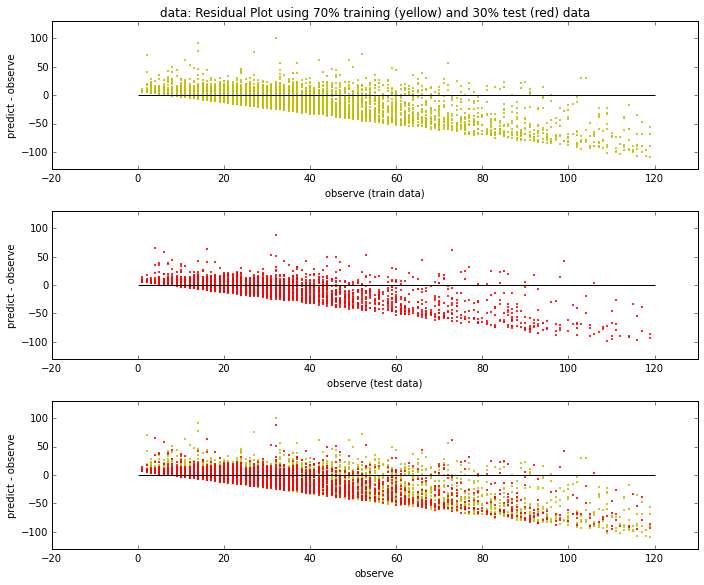

In [48]:
plt.figure(1)
plt.subplot(311)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1,edgecolor='y')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.title('data: Residual Plot using 70% training (yellow) and 30% test (red) data')
plt.ylabel('predict - observe')
plt.xlabel('observe (train data)')

plt.subplot(312)
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1,edgecolor='r')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe (test data)')

plt.subplot(313)
plt.scatter(y2_train, lm2.predict(X2_train) - y2_train, c='y', s=1, edgecolor='y')
plt.scatter(y2_test, lm2.predict(X2_test) - y2_test, c='r', s=1, edgecolor='r')

plt.tight_layout()
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-20, 130, -130, 130])
plt.ylabel('predict - observe')
plt.xlabel('observe')

plt.show()

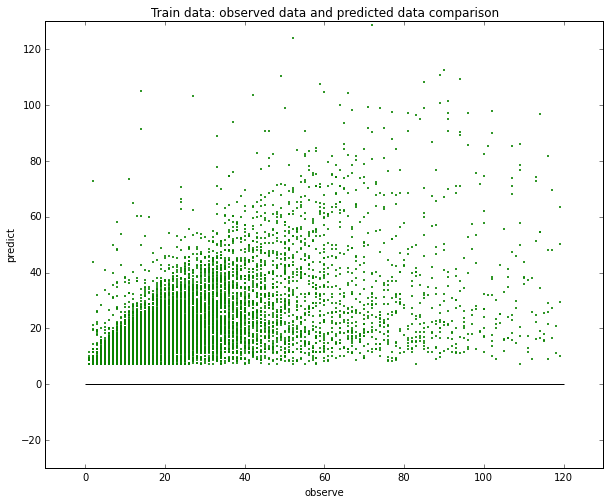

In [49]:
plt.figure(1)

plt.scatter(y2_train, lm2.predict(X2_train), c='y', s=1,edgecolor='g')
plt.hlines(y=0, xmin=0, xmax=120)
plt.axis([-10, 130, -30, 130])
plt.title('Train data: observed data and predicted data comparison')
plt.ylabel('predict')
plt.xlabel('observe')
plt.show()

z: 7.53155513297
sort data: 0.000898608469925


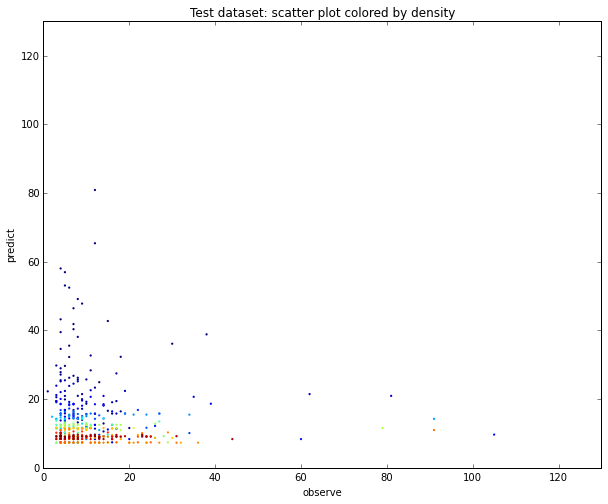

In [50]:
x2 = y2_test
y2 = lm2.predict(X2_test)

# Calculate the point density
start = timeit.default_timer()
xy2 = np.vstack([x2,y2])
z2 = gaussian_kde(xy2)(xy2)
stop = timeit.default_timer()
print 'z:', stop - start

# Sort the points by density, so that the densest points are plotted last
start = timeit.default_timer()
idx = z2.argsort()
stop = timeit.default_timer()
print 'sort data:', stop - start

x2, y2, z2 = x2[idx], y2[idx], z2[idx]
fig, ax = plt.subplots()
ax.scatter(x2, y2, c=z2, s=5, edgecolor='')

plt.axis([0, 130, 0, 130])
plt.title('Test dataset: scatter plot colored by density')
plt.ylabel('predict')
plt.xlabel('observe')

plt.show()

# Plotting Scatter, by appling the dewell time model with the rest 30% data

In [51]:
#try the [door_open_sec] as y variable!
lm3 = smf.ols(formula = 'DOOR_OPEN_SEC ~ ONS + OFFS + ThreeDoorsArtic + TwoDoorsArtic + rapid_ride + max_pasg + OnsTwoDoorsArtic + OffsTwoDoorsArtic + OnsThreeDoorsArtic + OffsThreeDoorsArtic + OnsRapid + OffsRapid', data = df_train).fit()
print lm3.summary()

                            OLS Regression Results                            
Dep. Variable:          DOOR_OPEN_SEC   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     2188.
Date:                Thu, 03 Mar 2016   Prob (F-statistic):               0.00
Time:                        20:56:03   Log-Likelihood:            -1.2652e+05
No. Observations:               33292   AIC:                         2.531e+05
Df Residuals:                   33279   BIC:                         2.532e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               5.9155    

In [52]:
X3_train = df_train[['ONS', 'OFFS', 'Artic','ON+OFF', 'ThreeDoorsArtic', 'TwoDoorsArtic', 'rapid_ride', 'max_pasg', 
                     'OnsTwoDoorsArtic','OffsTwoDoorsArtic', 'OnsThreeDoorsArtic', 'OffsThreeDoorsArtic', 
                     'OnsRapid', 'OffsRapid']]
X3_test = df_test[['ONS', 'OFFS','Artic','ON+OFF', 'ThreeDoorsArtic', 'TwoDoorsArtic', 'rapid_ride', 'max_pasg', 
                     'OnsTwoDoorsArtic','OffsTwoDoorsArtic', 'OnsThreeDoorsArtic', 'OffsThreeDoorsArtic', 
                     'OnsRapid', 'OffsRapid']]
y3_train = y_train
y3_test = y_test

In [53]:
#Estimate dwell time for the 'test' dataset
df_est = []
df_est = pd.DataFrame(lm3.predict(X3_test), index = X3_test.index, columns = ['Dwell_Time_Esti'])
test = pd.concat([X3_test, df_est], axis=1, join='inner')
test.head()

,ONS,OFFS,Artic,ON+OFF,ThreeDoorsArtic,TwoDoorsArtic,rapid_ride,max_pasg,OnsTwoDoorsArtic,OffsTwoDoorsArtic,OnsThreeDoorsArtic,OffsThreeDoorsArtic,OnsRapid,OffsRapid,Dwell_Time_Esti
102736,0.000,1.000,1,1.000,0,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,7.421
49228,0.000,1.000,1,1.000,0,1,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,7.421
105100,4.000,0.000,1,4.000,0,1,0.000,4.000,4.000,0.000,0.000,0.000,0.000,0.000,16.842
105103,3.000,1.000,1,4.000,0,1,0.000,3.000,3.000,1.000,0.000,0.000,0.000,0.000,16.167
33687,2.000,1.000,1,3.000,0,1,0.000,2.000,2.000,1.000,0.000,0.000,0.000,0.000,13.578


In [54]:
test.columns

Index([u'ONS', u'OFFS', u'Artic', u'ON+OFF', u'ThreeDoorsArtic',
       u'TwoDoorsArtic', u'rapid_ride', u'max_pasg', u'OnsTwoDoorsArtic',
       u'OffsTwoDoorsArtic', u'OnsThreeDoorsArtic', u'OffsThreeDoorsArtic',
       u'OnsRapid', u'OffsRapid', u'Dwell_Time_Esti'],
      dtype='object')

5365 5365


C:\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


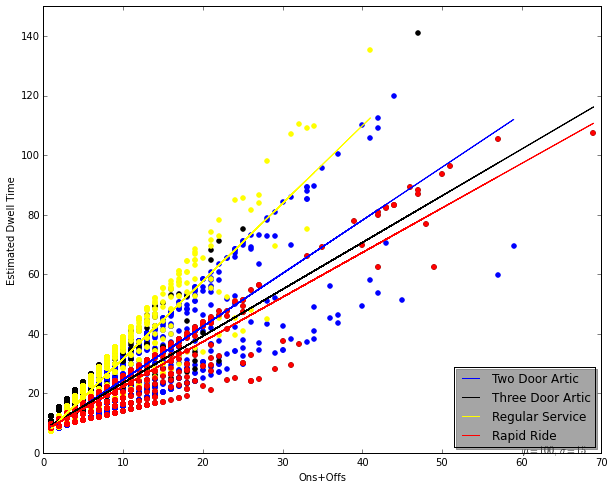

In [55]:
#Create dataframe for specific groups
test_TwoDoorsArtic = test[(test.TwoDoorsArtic==1)]
test_ThreeDoorsArtic = test[(test.ThreeDoorsArtic==1)]
test_StandardService = test[test.Artic==0]
test_RapidRide = test[test.rapid_ride==1]

fig, ax = plt.subplots()

# plot the data itself
x1 = test_TwoDoorsArtic['ON+OFF']
y1 = test_TwoDoorsArtic['Dwell_Time_Esti']
print len(x1), len(y1)
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Two Door Artic')

x2 = test_ThreeDoorsArtic['ON+OFF']
y2 = test_ThreeDoorsArtic['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x2, y2, color = 'black')
#plot the trend line
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='black', label='Three Door Artic')

# plot the data itself
x3 = test_StandardService['ON+OFF']
y3 = test_StandardService['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x3, y3, color = 'yellow')
#plot the trend line
fit = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit[0] * x3 + fit[1], color='yellow', label= 'Regular Service')

x4 = test_RapidRide['ON+OFF']
y4 = test_RapidRide['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x4, y4, color = 'red')
#plot the trend line
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='red', label= 'Rapid Ride')


plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

In [531]:
print 'end'

end
